A common part of emergency planning is the shelter in place. More often than not trying to outrun whatever calamity is happening at a chemical plant is more dangerous than finding a safe place to ride it out, which is usually the lunch room or somewhere like that. Sometimes facilities have different shelter in place locations depending on what the hazard is -- for example a severe weather shelter location may not be where you go for a toxic gas release.

Naturally, when evaluating the consequences of a release, one wants to evaluate the effectiveness of a shelter in place location. This usually involves looking at some building infiltration model.

Another situation in which building infiltration has come up in recent years is forest fires, and I think this presents a unique opportunity to validate the models and the selection of shelter in place locations. I'm not talking about sheltering in place because the forest fire is at the plant boundary, I'm talking about *smoke days* where forest fire smoke blows in and blankets the whole area in higher than usual airborne particulates.

## The Scenario

At least where I live, in Alberta, this is not an uncommon event. Every other year, it seems, there is a large forest fire either in the northern boreal forest or in the Rocky Mountains and the smoke from these enormous fires will blanket the entire province.

This is the view from my apartment of one of the last big smoke days, on May 30th of 2019

::: {#fig-view}
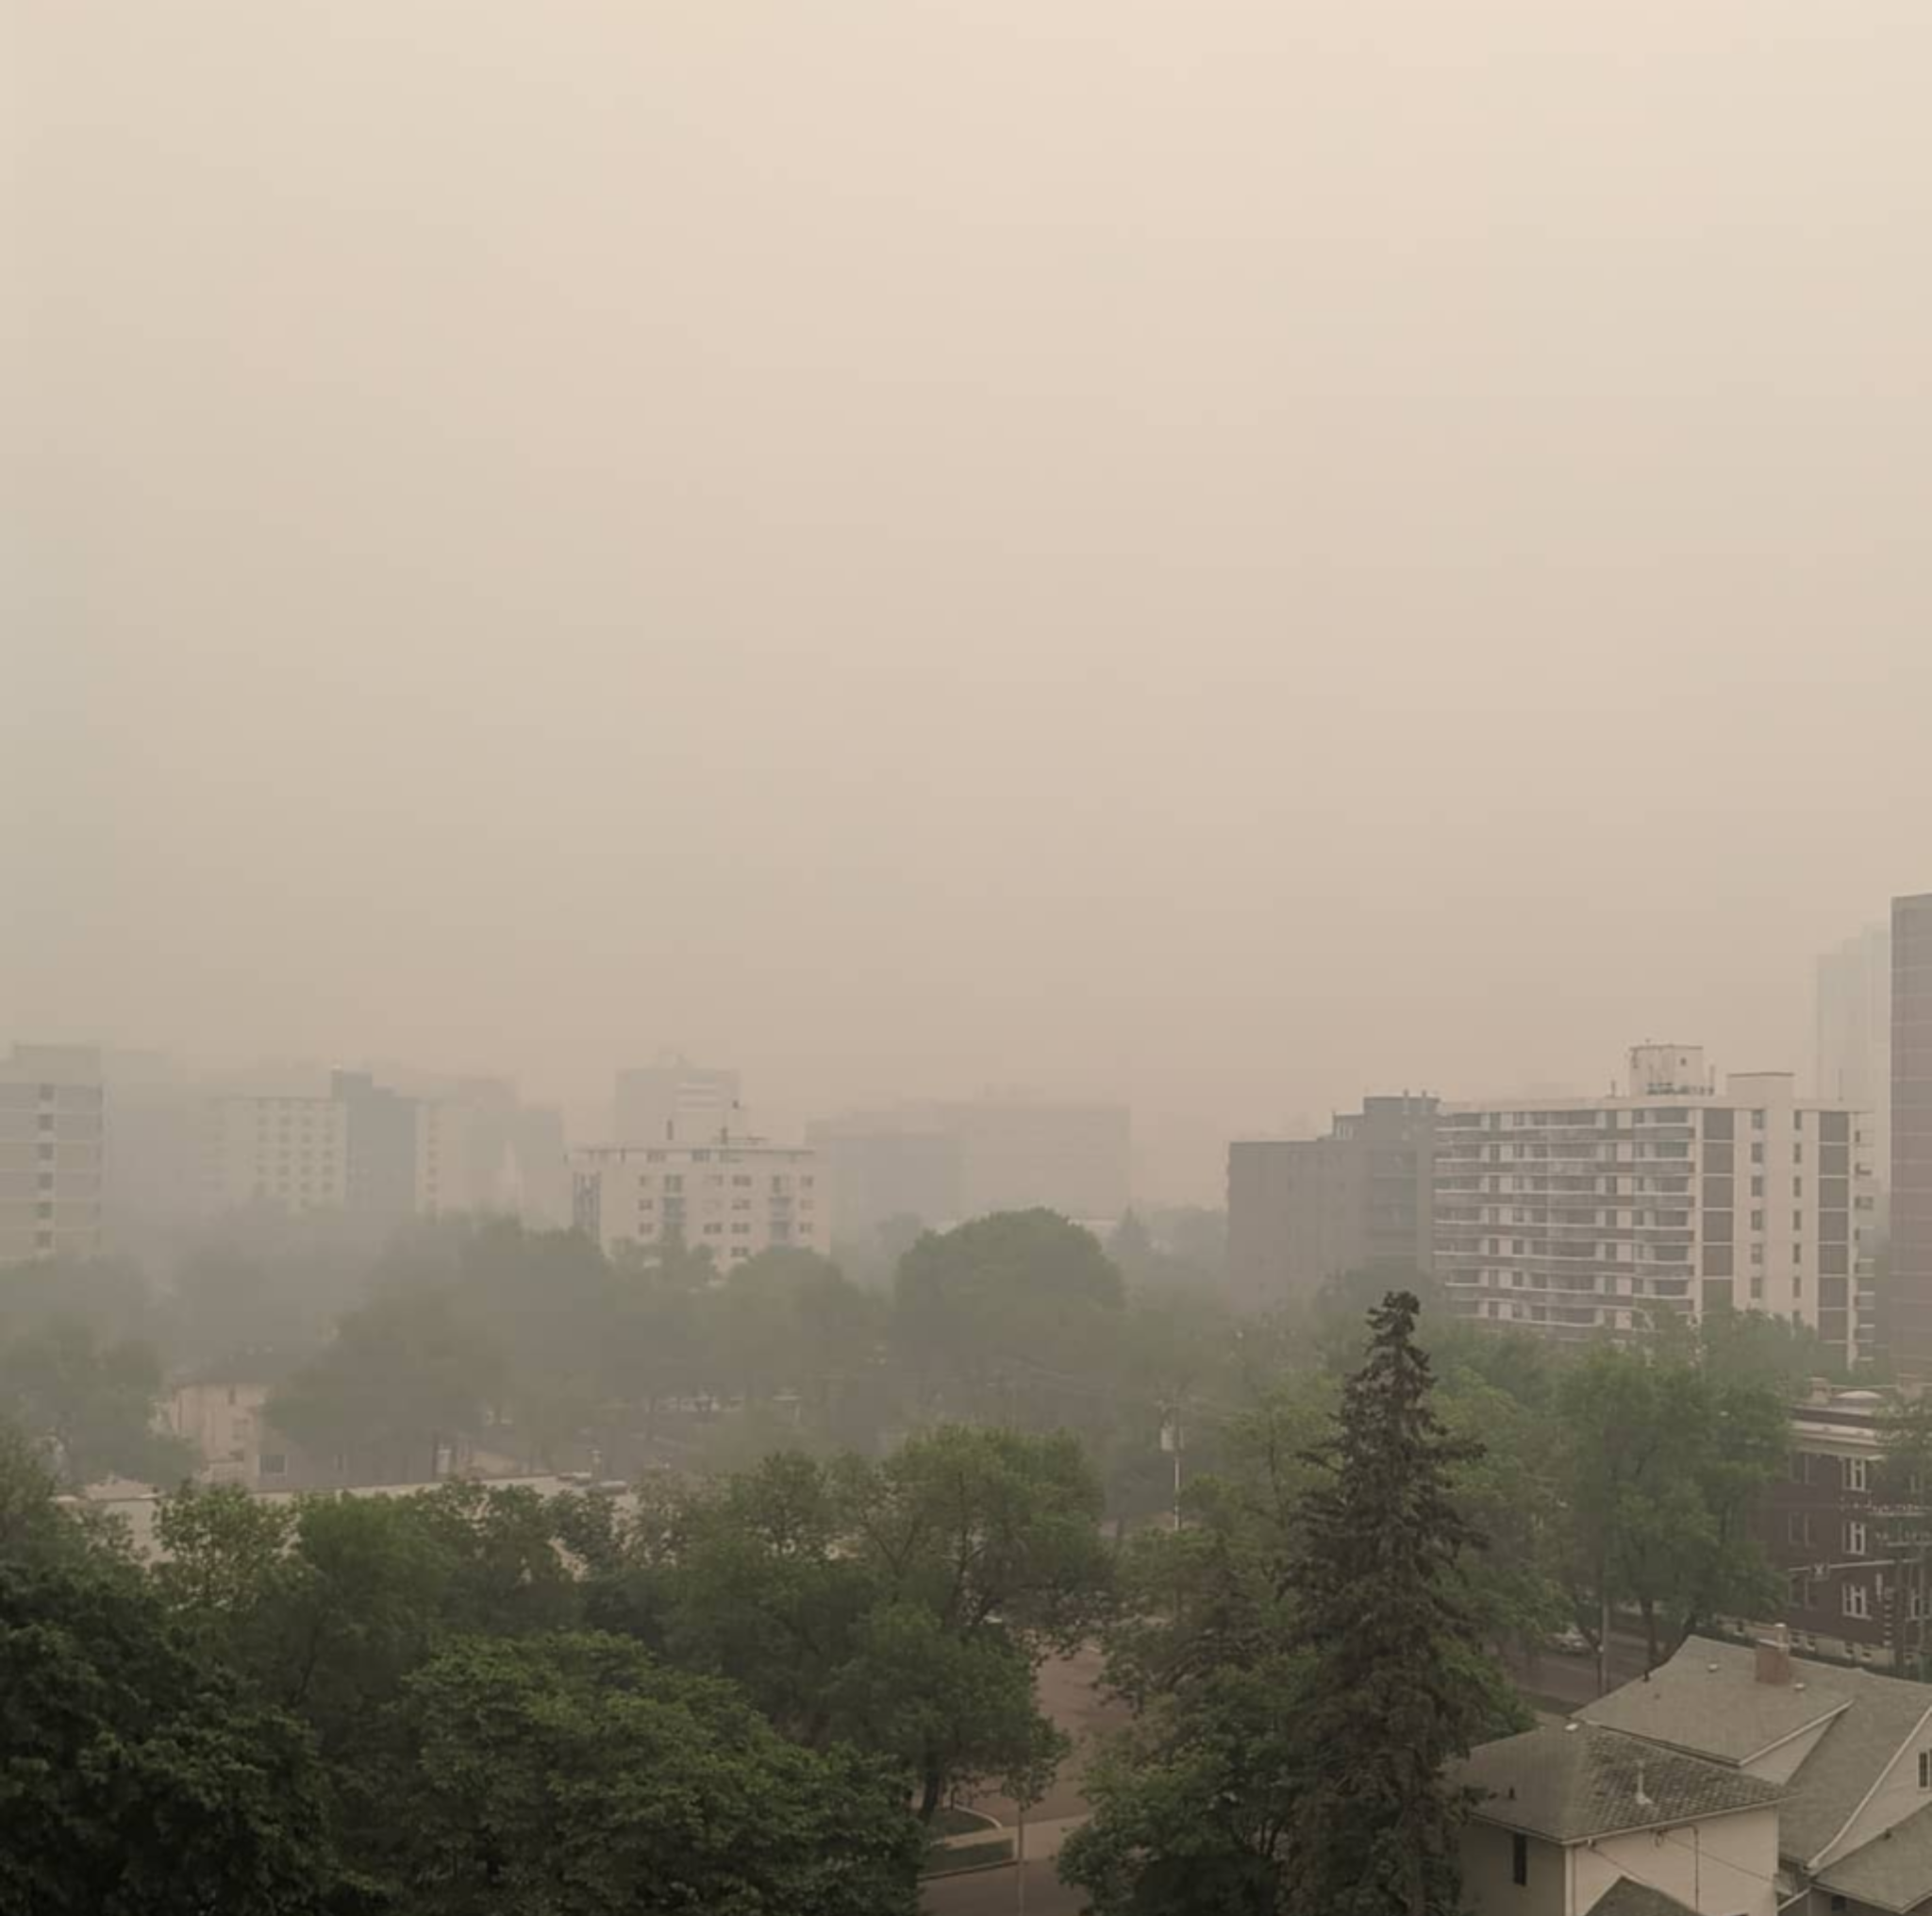

The view from my apartment on May 30th, 2019, when the city experienced a significant air quality event due to wildfire smoke.
:::

This haze is unsurprisingly bad for outdoor air quality, but what does it do for indoor air quality? Typically people shut-down air handling systems to minimize the smoke infiltration and wait it out (which is why I think it is a good proxy for a release scenario), so a model of how quickly smoke, or airborne particulates, can work its way into the building is useful to have.

## Ambient Air Data

The outdoor concentration of airborne particulates, PM2.5, is needed. There are several air monitoring stations throughout Alberta, with the closest one to me being the Edmonton Central station. Hourly air quality data can be downloaded as a csv from [Alberta's Air Data Warehouse](https://airdata.alberta.ca/reporting/Download/MultipleParameters) and imported into julia as a dataframe.

In [1]:
using CSV, DataFrames, Dates, Pipe

I am using the `Pipe.jl` package to streamline the data manipulation process. It takes the output from what is on the left of `|>` and puts it in where the `_` is on the right, which is very convenient when chaining together several single-input-single-output functions.

In [2]:
data_file = "data/Edmonton Central pm2.5.csv"

# import the csv file, remove missing data
# insert a column for the time since the start of the dataset in hours

ambient_data = @pipe data_file |>
    CSV.File( _ ; 
             dateformat="mm/dd/yyyy HH:MM:SS", 
             types=[DateTime, DateTime, Float64], 
             header=16) |>
    DataFrame(_) |>
    rename(_, "MeasurementValue" => "conc") |>
    rename(_, "IntervalStart" => "date") |>
    select(_, Not([2])) |>
    hcat(_, Dates.value.( _.date - _.date[1])/3.6e6) |>
    rename(_, "x1" => "time") |>
    dropmissing(_) 

first(ambient_data, 6)

,date,conc,time
,DateTime,Float64,Float64
1,2019-05-24T00:00:00,16.0,0.0
2,2019-05-24T01:00:00,7.0,1.0
3,2019-05-24T02:00:00,9.0,2.0
4,2019-05-24T03:00:00,13.0,3.0
5,2019-05-24T04:00:00,9.0,4.0
6,2019-05-24T05:00:00,10.0,5.0


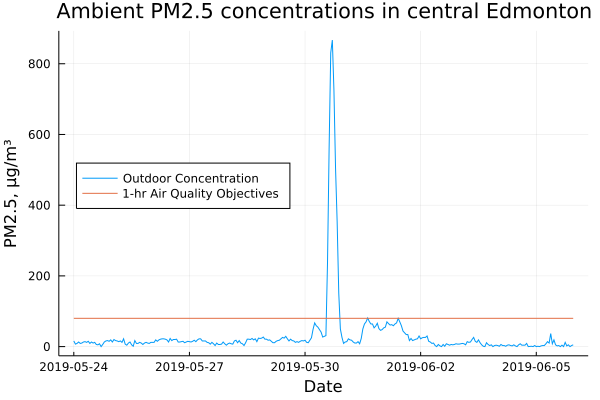

In [3]:
#| echo: false
#| label: fig-amb_pm
#| fig-cap: "Ambient pm2.5 concentrations from the Central Edmonton air quality monitoring station, May 24th - June 5th 2019."

using Plots

plot(ambient_data.date, ambient_data.conc, lab="Outdoor Concentration",
     title="Ambient PM2.5 concentrations in central Edmonton",
     ylabel="PM2.5, μg/m³",
     xlabel="Date",
     legend=:left)
plot!([ambient_data.date[1], ambient_data.date[end]], 
      [80.0, 80.0], lab="1-hr Air Quality Objectives")

In this case I restricted the dataset to just the PM2.5 concentration, since that is all I am interested in, and to a window of time around May 30th. The data clearly shows that May 30th had a big spike in airborne particulates, well in excess of the ambient air quality objectives. Though it was somewhat hazy in the days before and after too.

## Infiltration Models

Building infiltration models can range from highly detailed CFD simulations of indoor airflow to simple "fully mixed" models that assume a single average indoor concentration. This second type is the easiest to use and a good start for screening scenarios. It is a simple differential equation that assumes the rate of infiltration is proportional to a ventilation rate, λ, and the concentration difference between the outside and inside air[@lees-1996 section 15.51]


$$ \frac{d}{dt} c = f \left( c, \lambda, t \right) = \lambda \cdot \left( c_o(t) - c \right)$$

The outside concentration, $c_o$, can be a constant, but it is more usefully thought of as a function of time. In practice the ventilation rate, λ, is usually taken to be a constant, but it is a function of ambient conditions and could be implicitly made a function of time as well.

This model is for for a single zone or single cell building, where the interior air is assumed to be well mixed and at a single uniform pressure and concentration. This works well for houses, non-segmented industrial buildings, and small open plan commercial buildings. For much larger buildings, with many zones, there are multiple zone models of various scales of complexity.

In [4]:
using Interpolations, OrdinaryDiffEq

The function below represents the right-hand-side of the differential equation in standard form, with the outside concentration as a generic function of time that is passed as a parameter. For convenience later on, I also created a function that takes the outside concentration and returns a callable with that pre-set.

The order of arguments is important here, `OrdinaryDiffEq` expects the arguments to be in the order unknowns, parameters, time, where both the unknowns and parameters can be vectors (if there's more than one)

In [5]:
#| output: false

f(c, λ, t; cₒ=zero) = λ*(cₒ(t) - c)

f(g) = (c, λ, t) -> f(c, λ, t; cₒ=g)

f (generic function with 2 methods)

### Natural Ventilation

Any structure, unless it is hermetically sealed, has some natural ventilation rate. This comes from leaks around doorframes, through ventilation systems (even when turned off), and other breaks in the building envelope. This natural ventilation rate, λ, is reported in air changes per hour (ACH) and is, in general, a function of ambient conditions inside and outside the structure.

::: {#fig-nat-vent}
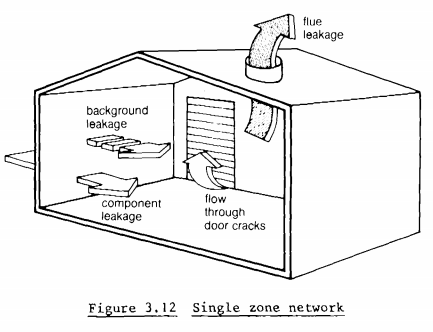

Natural ventillation mechanisms in a single zone building.
:::

The following plot is for a building infiltration model showing a building with windows open versus closed, showing the functional relationship between temperature differences and windspeed and the ventillation rate. Note the first plot is against the square root of the temperature difference.

::: {#fig-nat-vent-curves}
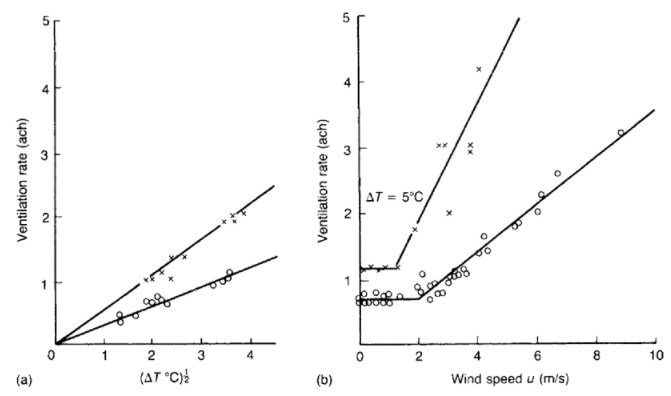

Natural ventillation rates as a function of temperature difference and windspeed.
:::

ASHRAE[@ashrae-2017 chapter 16] gives guidance on how to estimate the natural ventilation rate for single zone buildings, and a basic model of air leakage is


$$ Q = A_L \sqrt{ C_s \vert \Delta T \vert + C_w u^2 }$$

Where *Q* is the air leakage rate, in m³/s, $A_L$ is the effective air leakage area, in m², $\Delta T$ is the temperature difference between indoors and outdoors, *u* the windspeed, and $C_s$ and $C_w$ constants tabulated based on building height and extent of shelter from the wind (due to other buildings in the vicinity).

The ventilation rate is then simply the leakage rate divided by the building volume

$$ \lambda = {Q \over V } $$

This model effectively treats the leakage from the building like a leakage through a hole using Toricelli's law, and the one big unknown that needs to be determined is the effective air leakage area. This can be determined by working through the different parts of the building and counting the elements such as windows and vents, or it can be determined experimentally for a given building, either by using a tracer (SF₆ is common) or by using the a blower system to pressurize the building and measuring how much flow is required to raise the internal pressure by a fixed amount (such as by 50Pa).

This is a lot of work for a simple building infiltration screening. However this may have already been done for the design of the building, as the air leakage is a critical component in a building's overall thermal efficiency. If the data already exists for a given building, for other purposes, then why not use it, but if it isn't readily available then it is more practical to use tabulated values for representative buildings.

This can be tricky, though, as most tabulated values are for houses and how "leaky" a house is depends very strongly on where that house was constructed (and when). Many references, such as *Lees'* give values for British homes which are often much greater than equivalent values tabulated elsewhere for typical American and Canadian homes. Which could entirely be a function of local weather. The air tightness of a home where I live in Canada is probably a lot more important, especially on days when it is -30°C, than a similar home in the UK where such extremes are essentially unheard-of. Which is also putting aside the fact that commercial structures are quite different from houses and so these values may not be too representative either.

Typical values for Canadian homes in urban areas

| Level   | ACH  | 
|---------|:----:| 
| Tight   | 0.25 | 
| Average | 0.50 | 
| Leaky   | 1.0  | 


Typical values for houses in the US

| Conditions | Tight | Typical | Leaky | 
|------------|:-----:|:-------:|:-----:| 
| Mild       | 0.07  | 0.1     | 0.4   | 
| Moderate   | 0.2   | 0.3     | 1.0   | 
| Severe     | 0.3   | 0.5     | 1.6   | 


In this model of building infiltration the ASHRAE model could be used and, with a suitable dataset of outdoor temperature and windspeeds, the ventilation rate would be a function of time. But for simplicity I am going to assume that the change in windspeed and temperature from any given hour to the next is quite small and the ventillation rate can be assumed to be a constant.

This raises the obvious question of what impact windspeed has on the indoor concentration? At higher windspeeds the building ventilation rate is higher, and so more of what's outside ends up inside, however at higher windspeeds there is more mixing and the outdoor concentration will generally be lower. I would expect the effect of mixing would dominate, but this might be worth investigating further.

### Building Infiltration

Armed with some ideas of the building ventilation rate, the differential equation can be solved for different outdoor concentration scenarios. When defining the problem, above, I set the outdoor concentration as generic function of time that was passed as a parameter. This ODE is simple enough that it can be solved by hand for basic cases and easily numerically integrated for any well behaved set of initial conditions and outdoor concentrations.

For an example let's consider a sudden pulse of a pollutant, say the outside air is 100%(vol) during the pulse and 0 otherwise, a square wave.

In [6]:
#| output: false

function c_square(t; cmax=1, t1=5, t2=20)
    if (t >=t1) & (t <= t2)
        return cmax
    else
        return 0
    end
end

c_square (generic function with 1 method)

Assuming the initial indoor concentration to be zero, and with a suitable ventillation rate, this can be solved numerically.

The problem is defined using the `ODEProblem` function, which creates a problem object which the solver then solves. In this case using the `Tsit5` solver, the default for non-stiff problems. The solution returned is an object that contains both a vector of solutions, and times, but can also be called like a function to return an interpolated result. This way the solution acts like a continuous function of time.

In [7]:
#| output: false

λ₀ = 0.25 # ventilation rate, 0.25 h⁻¹
c0 = 0.0  # initial condition
tspan = (0.0, 25.0)
sys = f(c_square)

prb = ODEProblem(sys, c0, tspan, λ₀)
sln = solve(prb, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 21-element Vector{Float64}:
  0.0
  9.999999999999999e-5
  0.0010999999999999998
  0.011099999999999997
  0.11109999999999996
  1.1110999999999995
  3.0124180911369605
  3.9360174794709644
  4.825999306837707
  6.427356306743892
  7.122460439559985
  9.325990245711695
 10.957690343353278
 13.483371610275466
 16.045228594928744
 19.29907204614803
 20.08786902573348
 20.589778300373727
 22.751997851035014
 24.32353372237852
 25.0
u: 21-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.3041162472197622
 0.4151200609133462
 0.662848899812213
 0.7757846424653169
 0.8807519614853618
 0.9371492727627979
 0.9721334900070262
 0.8983098815648776
 0.7923773814908215
 0.4615032238831967
 0.31156429220055604
 0.2630881494791909

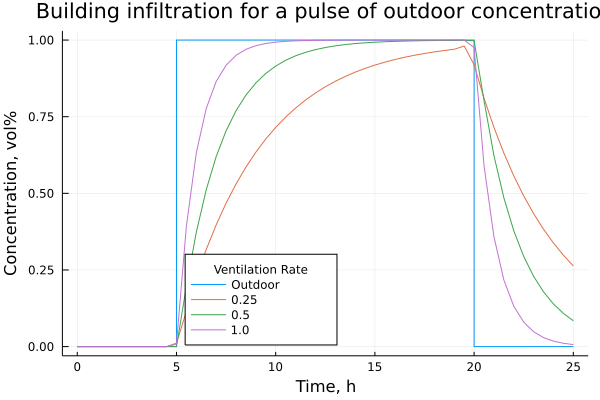

In [8]:
#| echo: false
#| label: fig-square-wave
#| fig-cap: "Building infiltration for a step-change in outdoor concentration."

λs = [0.25, 0.5, 1.0]
slns = [ solve(ODEProblem(f(c_square), c0, tspan, λ), Tsit5()) for λ in λs]
t = [t for t in 0:0.5:25]

plot([0, 5, 5, 20, 20, 25], [0, 0, 1, 1, 0, 0], lab="Outdoor")
plot!(t, [s.(t) for s in slns], lab=reshape(λs, (1,3)))
plot!(title="Building infiltration for a pulse of outdoor concentration", 
      ylabel= "Concentration, vol%", 
      xlabel="Time, h",
      legend=:bottom,
      legendtitle="Ventilation Rate",
      legendtitlefontsize=8)

Solving for the indoor concentration of pm2.5s using measured outdoor concentrations is essentially the same process, except instead of a simple square wave we have a timeseries of measured values.

The first step is to turn that timeseries into a continuous function, in this case I am using a simple linear interpolation.

In [9]:
#| output: false

cₒᵤₜ = LinearInterpolation(ambient_data.time, ambient_data.conc, extrapolation_bc = Interpolations.Flat())

311-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 16.0
  7.0
  9.0
 13.0
  9.0
 10.0
 13.0
 14.0
 12.0
 15.0
  9.0
 13.0
 10.0
  ⋮
  5.0
  2.0
  3.0
  0.0
  4.0
  0.0
 12.0
  2.0
  5.0
  0.0
  3.0
  5.0

The remaining steps are the same, since the model for building infiltration is the same (with the parameter and inital conditions as defined earlier). The only difference is the timespan is the full span of the timeseries and the outdoor concentration is the linear interpolation defined above.

In [10]:
#| output: false

tspan = (0.0, ambient_data.time[end])
sys = f(cₒᵤₜ)

prb = ODEProblem(sys, c0, tspan, λ₀)
sln = solve(prb, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 217-element Vector{Float64}:
   0.0
   9.999999999999999e-5
   0.0010999999999999998
   0.011099999999999997
   0.11109999999999996
   0.43838112612753194
   0.9934449766148701
   1.70102040165746
   2.4279145966110987
   3.2086225375753896
   3.798679573790602
   5.5240948148565305
   6.41826368964527
   ⋮
 300.64354697856885
 301.6667077765827
 302.75958151781504
 303.8823815896148
 304.74587295074906
 305.76338385468114
 306.59301827079383
 307.38397793761
 308.27787403970603
 309.05893096908295
 309.8255098556012
 311.0
u: 217-element Vector{Float64}:
  0.0
  0.00039998375013541545
  0.004398033930227189
  0.04419996882161998
  0.42452670244078944
  1.4523378607227269
  2.494934312714889
  3.3423521234338827
  4.351401797574474
  5.719822365071566
  6.438017216221852
  7.690000914973031
  8.699738146915037
  ⋮
 11.443150457282066
  9.389667902223454
  7.663271446205349
  6.162962794266983
  5.471191673701

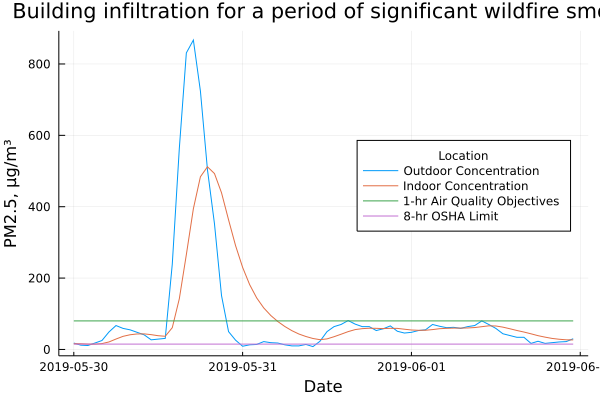

In [11]:
#| echo: false
#| label: fig-real-data
#| fig-cap: "Building infiltration using measured outdoor concentrations."

zoom_start = Date("05/30/2019", "mm/dd/yyyy")
zoom_stop = Date("06/02/2019", "mm/dd/yyyy")

@pipe ambient_data |>
    filter(row -> row.date >= zoom_start, _) |>
    filter(row -> row.date < zoom_stop, _) |>
    begin 
        plot(_.date, _.conc, lab="Outdoor Concentration")
        plot!(_.date, sln.(_.time), lab="Indoor Concentration")
        plot!([_.date[1], _.date[end]], 
              [80.0, 80.0], lab="1-hr Air Quality Objectives")
        plot!([_.date[1], _.date[end]], 
              [15.0, 15.0], lab="8-hr OSHA Limit")
        plot!(title="Building infiltration for a period of significant wildfire smoke", 
              ylabel= "PM2.5, μg/m³", 
              xlabel="Date",
              legend=:right,
              legendtitle="Location",
              legendtitlefontsize=8)
    end

We can see, much like in the square wave model, that the indoor concentration lags behind the outoor concentration but still rises significantly. Once the pulse in high pm2.5 ends the indoor concentration decays, but again with a delay. So there is a period after the smoke has blown over in which the pm2.5 concentration indoors can be higher than outdoors (a good time to open some windows and air the place out)

For some context I have added Alberta's Ambient Air Quality Objective for pm2.5s, clearly bad smoke days exceed that target but also indoor air quality can exceed it as well. Interestingly the indoor air quality may have exceeded workplace limits for airborne particulates through the whole period.

In [12]:
# max outdoor concentration

maximum(ambient_data.conc)

867.0

In [13]:
# max indoor concentration

maximum(sln.u)

501.877462902824

### Ventilation and Infiltration Time

If we assume a constant outdoor concentration, a constant ventilation rate, and an initial indoor concentration of zero, the model can be solved analytically to give

$$ { c_i \over c_o } = 1 - e^{-\lambda t}$$

Which leads us to ask, how long does it take for the indoor concentration to reach some fraction *x* of the outdoor concentration?

$$ x = 1 - e^{-\lambda t} $$

$$ t = { -\ln{\left( 1 - x \right)} \over \lambda } $$

For simplicity's sake let's assume $x = 0.5$.

In [14]:
#| output: false

t_x(λ; x=0.5) = -log(1-x)/λ

t_x (generic function with 1 method)

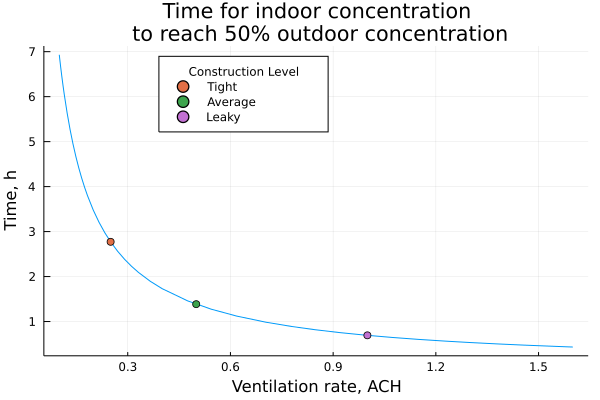

In [15]:
#| echo: false
#| label: fig-time
#| fig-cap: "The time to reach 1/2 the outdoor concentration as a function of ventillation rates."

λs = [0.25, 0.5, 1.0]
level = ["Tight", "Average", "Leaky"]

plot(t_x, 0.1, 1.6, lab=false)
plot!([[λ] for λ in λs], [[t_x(λ)] for λ in λs], seriestype=:scatter, lab=reshape(level, (1,3)))
plot!(title="Time for indoor concentration\n to reach 50% outdoor concentration", 
      ylabel= "Time, h", 
      xlabel="Ventilation rate, ACH",
      legend=:top,
      legendtitle="Construction Level",
      legendtitlefontsize=8)

This gives us a sense of how building tightness - the natural ventilation rate - impacts how long a shelter in place would be effective for. If the emergency is lasting for several hours then a shelter in place location would have to be highly air tight to be effective.

## Model Evaluation

A realistic shelter in place location is not going to be well mixed with the rest of the building. It will be an enclosed space that can be isolated from the building (e.g. by closing doors), and with an air handling system that can be isolated (unlike, say, a cafeteria where often the vents for clearing the air in the kitchen cannot be easily sealed). In this case the *effective* ventillation rate for that enclosed space, during a shelter in place, should be smaller than the ventillation rate for the building overall -- when the doors are open and a single zone model is perhaps more representative.

In this case we can use the outdoor smoke event as a test. Somewhat like a tracer test but in reverse and we are not controlling the tracer. If we knew in advance that a smoke day was coming, which given publicly available modeling such as [FireSmoke](https://firesmoke.ca/) is reasonable, we could close off the shelter in place location with some indoor monitoring set up in the middle of the room and watch what happens.

If things go like they have in the past, at least where I work, the air handling system is shutdown and people try and minimize their time outdoors (and thus time spent opening and closing outside doors). By tracking the indoor concentration as well as outdoor concentrations we can compare the model to reality -- does a single zone model work? do we need to incorporate weather conditions? -- and estimate an *effective* ventilation rate by fitting the ODE to the measured data.

At least that's the theory. I don't have measured indoor air data for the time in question so I am going to simulate some by assuming the model works and adding some random noise. In this case I am adding ±10% random noise to the results calculated earlier for λ=0.25.

In [16]:
using DiffEqParamEstim, Optim

Here I make a copy of the ambient data dataframe, `df`, and create a new column called `cin` for indoor concentration. This is the solution found earlier times a random error ±10%, then for good measure any columns with the concentration below zero are chopped off at zero since that is unphysical.

In [17]:
#| output: false
# Dummy data

df = deepcopy(ambient_data)

df.cin = sln.(df.time) .* ( 1 .+ 0.10*randn(size(df.time)) )
df.cin[ df.cin .< 0 ] .= 0

0-element view(::Vector{Float64}, Int64[]) with eltype Float64

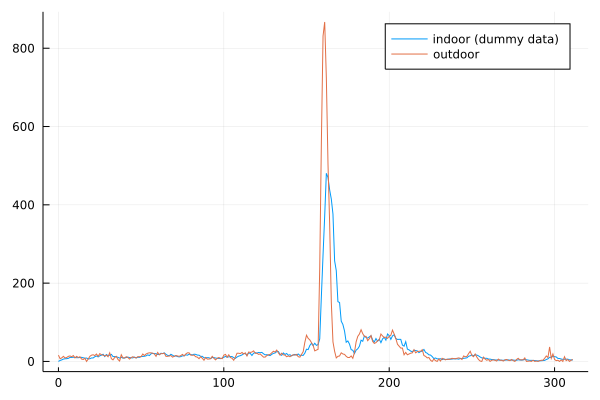

In [18]:
#| echo: false
#| label: fig-dummy-data
#| fig-cap: "Actual measured outdoor data and generated indoor data."

plot(df.time, [df.cin df.conc], lab=["indoor (dummy data)" "outdoor"])

The model can be fit to these two sets of data, essentially taking the outdoor concentration as a given and finding the best fit curve to the indoor concentration by solving the ODE repeatedly for different values of the parameter λ.

The major difference between this and simply solving the ODE is defining the loss function, in this case an L2 loss which is analogous to least squares, and then optimizing.

In [19]:
#| output: false

tspan = (0, df.time[end])
c0 = df.cin[1] # initial condition

sys = f(cₒᵤₜ)
p = [0.5] #initial guess of λ=0.5

prb = ODEProblem(sys, c0[1], tspan, p)
lossfn = L2Loss(df.time, df.cin)

cost_function = build_loss_objective(prb,Tsit5(),lossfn,
                                     maxiters=10000,verbose=false)

(::DiffEqObjective{DiffEqParamEstim.var"#37#42"{Nothing, Bool, Int64, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Iterators.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Float64, Tuple{Float64, Float64}, false, Vector{Float64}, ODEFunction{false, var"#2#3"{Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Gridded{Linear}, Tuple{Vector{Float64}}}, Gridded{Linear}, Throw{Nothing}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, DiffEqParamEstim.var"#41#47"{DiffEqParamEstim.var"#37#42"{Nothing, Bool, Int64, typeof(DiffEqParamEs

The optimization is looking for the parameter that minimizes the cost function, which in this case is the least-squares difference between the model and the "measured" data for indoor concentration. The minimum is well defined and close to λ=0.25, which is what we would expect given that was how the data was generated.

Note: the plot below is nice to look at but not something one would normally generate, since calculating each point involves solving the ODE and could be fairly resource intensive for any problem more complex than this simple model. It sort of defeats the point of using an optimization algorithm to find the minimum. It's just a nice visualization of what is happening in the background.

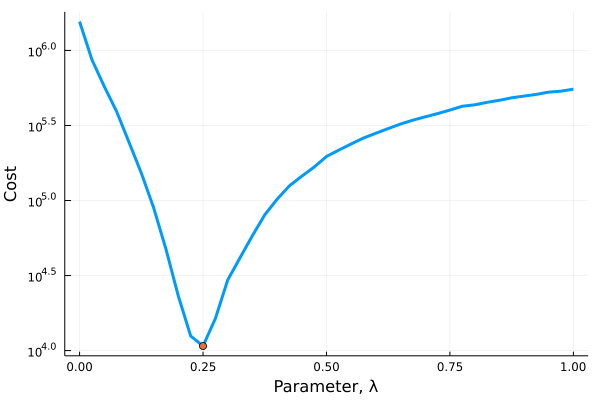

In [20]:
#| echo: false
#| label: fig-optim
#| fig-cap: "The cost landscape showing the optimal parameter λ"

vals = 0:0.025:1.0

plot(vals,[cost_function(i) for i in vals],yscale=:log10,
     xaxis = "Parameter, λ", yaxis = "Cost", lab=false,
     lw = 3)
plot!([λ₀], [cost_function(λ₀)], seriestype=:scatter, lab=false)

In [21]:
# optimize the cost function for parameters between 0 and 1

result = optimize(cost_function, 0.0, 1.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 2.363617e-01
 * Minimum: 9.520426e+03
 * Iterations: 27
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 28

In [22]:
λfit = result.minimizer[1]

0.2363617224674848

In [23]:
λfit/λ₀

0.9454468898699392

The best fit ventillation rate is quite close to the actual ventillation rate used to generate the data, which is what we would expect.

With an effective ventilation rate we can generate a best fit line

In [24]:
#| output: false

prb = ODEProblem(sys, c0[1], tspan, λfit)
fit = solve(prb, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 207-element Vector{Float64}:
   0.0
   9.999999999999999e-5
   0.0010999999999999998
   0.011099999999999997
   0.11109999999999996
   0.44703886152959627
   0.9106232605603086
   1.595817884545689
   2.041926434462546
   2.5553136538797094
   3.8179457488587616
   4.48966683446238
   5.332582822292136
   ⋮
 297.99484380879
 299.10542730010286
 299.90969857984885
 301.9432767676409
 303.2030355262181
 304.2908227884827
 305.3385299146007
 306.257360493603
 307.06729672455316
 308.15779560273086
 308.96640945182986
 311.0
u: 207-element Vector{Float64}:
  0.0
  0.0003781636504403689
  0.00415813869300294
  0.04179188814390752
  0.4016735461265836
  1.3990868568784498
  2.276407038866676
  3.0742239071979545
  3.62946868590011
  4.382036367176575
  6.270410741270164
  6.707423977485864
  7.3181969100214985
  ⋮
 12.375356036814885
 13.007486388621345
 12.783875142116944
  9.11850071436059
  7.057386765517766
  6

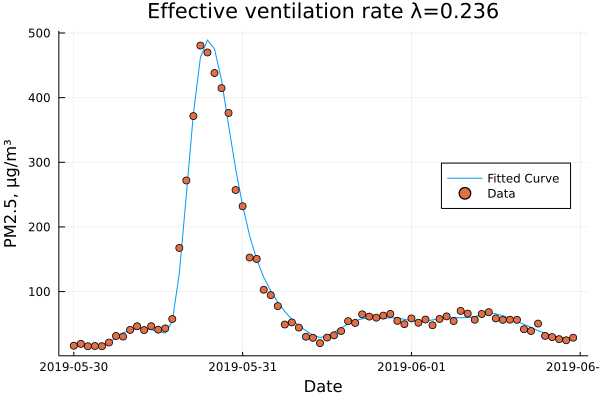

In [25]:
#| echo: false
#| label: fig-fit
#| fig-cap: "The linear ventillation model fitted to the indoor concentration."

zoom_start = Date("05/30/2019", "mm/dd/yyyy")
zoom_stop = Date("06/02/2019", "mm/dd/yyyy")

@pipe df |>
    filter(row -> row.date >= zoom_start, _) |>
    filter(row -> row.date < zoom_stop, _) |>
    begin 
        plot(_.date, fit.(_.time), lab="Fitted Curve")
        plot!(_.date, _.cin, seriestype = :scatter, lab="Data")
        plot!(title="Effective ventilation rate λ=$(round(λfit; digits=3))", 
              ylabel= "PM2.5, μg/m³", 
              xlabel="Date",
              legend=:right,
              #legendtitle="Package",
              legendtitlefontsize=8)
    end

## A Control Systems Approach

For people with a background in control systems and process dynamics, an obvious alternative way of writing the problem is in term of Laplace transforms and transfer functions.

$$ \frac{d}{dt} c = \lambda \cdot \left( c_o(t) - c \right)$$

with the change of variables $y = c(t) - c(0)$ and $u = c_o$

$$ y^\prime = \lambda u - \lambda y $$

Taking the Laplace transform of both sides
$$ s Y = \lambda U - \lambda Y $$

$$ Y = { \lambda \over { s + \lambda} } U $$

This can then be solved analytically for various inputs, $U$, or numerically for a given timeseries. In Julia this can be done with the `ControlSystems.jl` and `ControlSystemIdentification.jl` packages. This lets you define a system in terms of transfer functions and solve them that way.

I showed the more generic ODE approach at the start because this is more easily generalized to more complex models (e.g. by incorporating the functional dependence of λ on temperature and windspeed). Though the transfer function approach lends itself more simply to using different inputs to the same system, simply change $u$ and you get a different result, whereas the generic ODE has the input as part of the system definition, which I think is sort of messy (though maybe there's a better way of doing this that I don't know about?).

### Building Infiltration Model

The building infilration model is set up by simply defining the transfer function for the system and then simulating the response to the given input (the outdoor concentration in this case)

In [26]:
using ControlSystems, ControlSystemIdentification

In [27]:
u(x, t) = [cₒᵤₜ(t)]
t = 0:1:ambient_data.time[end]

sys = tf([λ₀], [1, λ₀])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
   0.25
-----------
1.0s + 0.25

Continuous-time transfer function model

Unlike the previous package, this returns the output, *y*, and time, *t*, as vectors with no interpolation or other information.

In [28]:
#| output: false

y, t, x = lsim(sys, u, t)

([0.0; 2.5024182405949023; … ; 3.8768680487186935; 3.9129792816949216], 0.0:1.0:311.0, [0.0; 10.009672962379609; … ; 15.507472194874774; 15.651917126779686], [16.0; 7.0; … ; 3.0; 5.0])

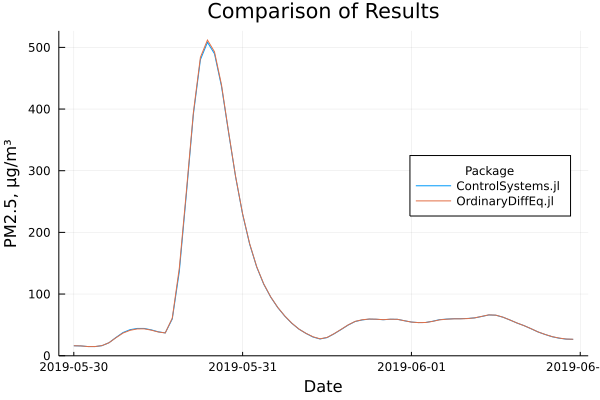

In [29]:
#| echo: false
#| label: fig-control-sys
#| fig-cap: "The linear ventillation model, using `ControlSystems.jl`"

zoom_start = Date("05/30/2019", "mm/dd/yyyy")
zoom_stop = Date("06/02/2019", "mm/dd/yyyy")

@pipe ambient_data |>
    filter(row -> row.date >= zoom_start, _) |>
    filter(row -> row.date < zoom_stop, _) |>
    begin 
        plot(_.date, y[Int.(_.time).+1], lab="ControlSystems.jl")
        plot!(_.date, sln.(_.time), lab="OrdinaryDiffEq.jl")
        plot!(title="Comparison of Results", 
              ylabel= "PM2.5, μg/m³", 
              xlabel="Date",
              legend=:right,
              legendtitle="Package",
              legendtitlefontsize=8)
    end

In [30]:
maximum(y)

508.2191947911374

The two approaches produce almost identical answers, which is not too surprising as the same ODE package and solver (Tsit5) is being used under the hood of `ControlSystems.jl` to solve this (I believe the only difference is one is using a variable time-step and the other a fixed time step, but I could be wrong).

### Model Evaluation

For the purposes of fitting the model to the data, we note that the model is an ARX model, i.e. it is of the form

$$ A(s) Y = B(s) U + D $$

where $A(s)$ and $B(s)$ are polynomials in *s*, and use the `ControlSystemIdentification.jl` package to fit the model, generating a fitted transfer function.

In this simple approach the parameters of $A(s)$ and $B(s)$ are allowed to be different, and in general you could fit a variety of models and use this as a jumping off point to explore potentially better models of infiltration.

If you are more interested in an empirical model, fitted to timeseries data, this approach can be much simpler than the model driven approach taken above with fitting the ODE to the data. Especially when incorporating other elements like windspeed and temperature.

In [31]:
# generates the discrete timeseries data with a sample time of 1

d = iddata(df.cin, df.conc, 1)

InputOutput data of length 311 with 1 outputs and 1 inputs

In [32]:
# finds the best fit transfer function with numerator order 1 and denominator order 1

model_tf = arx(d, 1, 1)

TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
  0.22305776166128505
------------------------
1.0z - 0.738488961457766

Sample Time: 1 (seconds)
Discrete-time transfer function model

In [33]:
#| output: false
# generate the best fit line

y_fit, t_fit, _ = lsim(model_tf, u, t)

([0.0; 3.5689241865805608; … ; 3.1395198050145106; 2.987674005265109], 0.0:1.0:311.0, [0.0; 16.0; … ; 14.07491844996587; 13.394171908718045], [16.0; 7.0; … ; 3.0; 5.0])

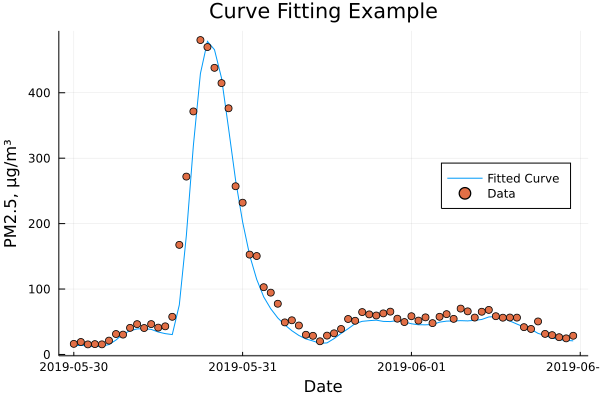

In [34]:
#| echo: false
#| label: fig-arx
#| fig-cap: "The linear ventillation model fitted to indoor concentrations using `ControlSystemIdentification.jl`"

zoom_start = Date("05/30/2019", "mm/dd/yyyy")
zoom_stop = Date("06/02/2019", "mm/dd/yyyy")

@pipe df |>
    filter(row -> row.date >= zoom_start, _) |>
    filter(row -> row.date < zoom_stop, _) |>
    begin
        t = convert.(Int, _.time) .+ 1
        plot(_.date, y_fit[t], lab="Fitted Curve")
        plot!(_.date, _.cin, seriestype = :scatter, lab="Data")
        plot!(title="Curve Fitting Example", 
              ylabel= "PM2.5, μg/m³", 
              xlabel="Date",
              legend=:right,
              #legendtitle="Package",
              legendtitlefontsize=8)
    end

## References
::: {#refs}
:::